In [196]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

pd.set_option('display.max_columns', None)

In [197]:
shot_metrics_df = pd.read_csv("shot_metric_df.csv")
shot_metrics_df.head()

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   
1           1  3c527d7b-6932-4190-8424-d1d3dcdd6a4d        191.0     1.0   
2           2  157da96f-2535-42f1-aaa4-273dc8ae2f12        368.0     1.0   
3           3  6a0404a3-2dd6-44d2-8c70-15bb2f858b82        535.0     1.0   
4           4  c06abd5a-b096-47eb-8352-6a5470db6d83        629.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   
1  00:05:11.529     5.0    11.0        11.0  1.023995       0.000000   
2  00:10:51.930    10.0    51.0        21.0  0.363535       0.000000   
3  00:14:17.334    14.0    17.0        27.0  1.067938       0.000000   
4  00:17:42.690    17.0    42.0        30.0  0.687717       0.047946   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   
1        0.034124    -0.034124           0.009421            0.009421   
2        0.204285    -0.204285           0.006885            0.006885   
3        0.095475    -0.095475           0.008562            0.008562   
4        0.076592    -0.028646           0.008465            0.008465   

   obv_against_net  obv_total_net under_pressure  type_id type_name  \
0              0.0       0.027997           True     16.0      Shot   
1              0.0      -0.034124            NaN     16.0      Shot   
2              0.0      -0.204285            NaN     16.0      Shot   
3              0.0      -0.095475            NaN     16.0      Shot   
4              0.0      -0.028646            NaN     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   
1                36.0      Manchester City              7.0    From Goal Kick   
2                36.0      Manchester City              3.0    From Free Kick   
3                34.0              Burnley              4.0     From Throw In   
4                34.0              Burnley              3.0    From Free Kick   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   
1     36.0  Manchester City        88.4        46.0        0.00   
2     36.0  Manchester City       114.7        46.6        1.08   
3     34.0          Burnley       104.7        31.0        0.00   
4     34.0          Burnley       107.2        26.6        0.00   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   
1               207b5c5a-ff48-4534-a5e2-0f83b20df80a     3089.0   
2               764d5d53-f1a1-4d37-9f78-b549101782c5    23616.0   
3               200cd1f9-50d7-4e73-9143-106f764722f8   256682.0   
4               8ebcd607-df4e-495e-8062-9cbf005d4fdf    48335.0   

            player_name  position_id          position_name  statsbomb_xg  \
0         Erling Håland         23.0         Center Forward      0.166126   
1       Kevin De Bruyne         13.0  Right Center Midfield      0.023693   
2         Erling Håland         23.0         Center Forward      0.142146   
3         Luca Koleosho         17.0             Right Wing      0.083945   
4  Mohamed Zeki Amdouni         23.0         Center Forward      0.085442   

   goal  penalty   body_part  opposition_in_triangle   gameId  match_date  \
0   1.0      0.0   Left Foot                     1.0  3892755  2023-08-11   
1   0.0      0.0  Right Foot                     2.0  3892755  2023-08-11   
2   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
3   0.0      0.0  Right Foot                     1.0  3892755  2023-08-11   
4   0.0      0.0   Left Foot                     1.0  3892755  2023-08-11   

   Count HI_now  Count HI_ha

In [198]:
good_shooters = shot_metrics_df[["player_id","statsbomb_xg"]].groupby("player_id",as_index=False).count().sort_values(by="statsbomb_xg", ascending=False)
good_shooters = good_shooters[good_shooters["statsbomb_xg"]>99]
shot_metrics_df =  shot_metrics_df[shot_metrics_df["player_id"].isin(good_shooters.player_id)]

In [199]:
shot_metrics_df["age"]= (pd.to_datetime(shot_metrics_df["match_date"])-pd.to_datetime(shot_metrics_df["birth_date"]))/pd.Timedelta(days=365.25)
shot_metrics_df["age"]= shot_metrics_df["age"].astype(int)

<Axes: ylabel='Density'>

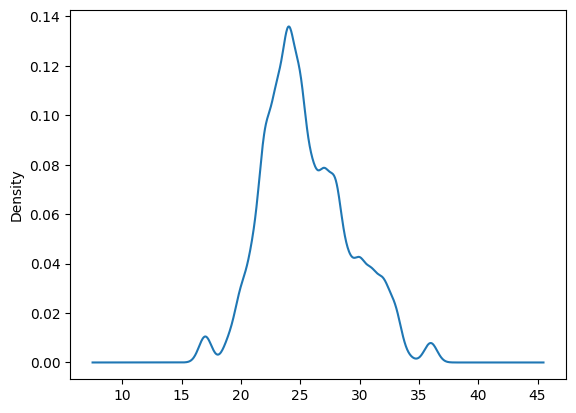

In [200]:
shot_metrics_df["age"].plot.density()

In [201]:

variable_list = [
    "High Intensity (HI) Distance_now", "High Intensity (HI) Distance_half", "High Intensity (HI) Distance_game", 
    "High Speed Running (HSR) Distance_now", "High Speed Running (HSR) Distance_half", "High Speed Running (HSR) Distance_game", 
    "Running Distance_now", "Running Distance_half", "Running Distance_game", 
    "Sprinting Distance_now", "Sprinting Distance_half", "Sprinting Distance_game", 
    "Total Distance_now", "Total Distance_half", "Total Distance_game", 
    "Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    "Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    "High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    "Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    "Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    "Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    "High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    "Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    "Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    "Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    "High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    "Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]


In [202]:
#clean df for ML use
shot_metrics_df =shot_metrics_df[shot_metrics_df.penalty==0]
shot_metrics_df = shot_metrics_df.fillna(0)
shot_metrics_df.under_pressure = np.where(shot_metrics_df.under_pressure==True,1,0)


In [203]:
#leave spanish clubs out
#clubs to leave out of training

test_clubs = [
    "Athletic Club",
    "Getafe",
    "Real Betis",
    "Girona",
  "Las Palmas",
    "Sevilla",
    "Celta Vigo",
   "Deportivo Alavés",
     "Osasuna",
     "Barcelona",
    "Valencia",
     "Rayo Vallecano",
    "Real Sociedad",
     "Real Madrid",
     "Mallorca",
    "Villarreal",
    "Atlético Madrid"
    ]

In [204]:
shot_metrics_df.head(1)

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   

     player_name  position_id   position_name  statsbomb_xg  goal  penalty  \
0  Erling Håland         23.0  Center Forward      0.166126   1.0      0.0   

   body_part  opposition_in_triangle   gameId  match_date  Count HI_now  \
0  Left Foot                     1.0  3892755  2023-08-11           1.2   

   Count HI_half  Count HI_game  Count HSR_now  Count HSR_half  \
0            0.0            0.0            1.0             0.0   

   Count HSR_game  Count High Acceleration_now  Count High Acceleration_half  \
0             0.0                          0.2                           0.0   

   Count High Acceleration_game  Count High Deceleration_now  \
0                           0.0                          0.4   

   Count High Deceleration_half  Count High Deceleration_game  \
0                           0.0                           0.0   

   Count Medium Acceleration_now  Count Medium Acceleration_half  \
0                            6.8                             0.0   

   Count Medium Acceleration_game  Count Medium Deceleration_now  \
0                             0.0                            4.4   

   Count Medium Deceleration_half  Count Medium Deceleration_game  \
0                             0.0                             0.0   

   Count Sprint_now  Count Sprint_half  Count Sprint_game  \
0               0.2                0.0                0.0   

   High Intensity (HI) Distance_now  High Intensity (HI) Distance_half  \
0                         17.017352                                0.0   

   High Intensity (HI) Distance_game  High Speed Running (HSR) Distance_now  \
0                                0.0                              15.196193   

   High Speed Running (HSR) Distance_half  \
0                                     0.0   

   High Speed Running (HSR) Distance_game  M/min_now  M/min_half  M/min_game  \
0                                     0.0  20.433466         0.0         0.0   

   Max Speed_now  Max Speed_half  Max Speed_game  Running Distance_now  \
0       5.187833             0.0             0.0             37.352316   

   Running Distance_half  Running Distance_game  Sprinting Distance_now  \
0                    0.0                    0.0                1.821159   

   Sprinting Distance_half  Sprinting Distance_game  Total Distance_now  \
0                      0.0                      0.0          306.501986   

   Total Distance_half  Total Distance_game  Count HI_1_week  \
0                  0.0                  0.0              0.0   

   Count HSR_1_week  Count High Acceleration_1_week  \
0               0.0                             0.0   

   Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                             0.0                               0.0   

   Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                               0.0                  0.0   

   High Intensity (HI) Distance_1_week  \
0                        

In [205]:
ML_data= shot_metrics_df[["team_name","goal", "position_name","under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle"]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
position_name_onehot = pd.get_dummies(ML_data.position_name, 
    prefix="position_name")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot,position_name_onehot], axis=1).drop(["play_pattern_name","body_part","position_name"],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

In [206]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [207]:

# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",#logitraw
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 6.60


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.851
ROC AUC: 0.724


In [208]:
statsbomb_test = np.where(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg>0.5,1,0)
statsbomb_actual = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].goal)
statsbomb_proba = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg)

In [209]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[859,  23],
       [132,  29]])

In [210]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[875,   7],
       [129,  32]])

In [211]:
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.851
ROC AUC: 0.724


In [212]:
acc = accuracy_score(statsbomb_actual,statsbomb_test )
roc = roc_auc_score(statsbomb_actual, statsbomb_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.870
ROC AUC: 0.785


In [213]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot',
       'position_name_Center Attacking Midfield',
       'position_name_Center Defensive Midfield',
       'position_name_Center Forward', 'position_name_Left Attacking Midfield',
       'position_name_Left Back', 'position_name_Left Center Forward',
       'position_name_Left Center Midfield',
       'position_name_Left Defensive Midfield', 'position_name_Left Midfield',
       'position_name_Left Wing', 'position_name_Left Wing Back',
       'position_name_Right Attacking Midfield', 'position_name_Right 

from autogluon.tabular import TabularPredictor
import numpy as np

# Compute class weights
neg, pos = np.bincount(y_train)
scale = neg / pos

# Assign weights: higher weight for goals (minority class)
weights = np.where(y_train == 1, scale, 1.0)

# Add weights column to training data
train_with_weights = X_train.copy()
#train_with_weights["weight"] = weights

# Fit AutoGluon with weights
predictor = TabularPredictor(
    label="goal",
    eval_metric="roc_auc",#""       # better than accuracy for imbalanced classes
    problem_type="binary"
).fit(
    training_data,
    #sample_weight="weight",
    presets="best_quality",
    time_limit=900
)

autogluon roc_auc 15 minutes
Accuracy: 0.906
ROC AUC: 0.777

from autogluon.tabular import TabularPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming predictor is already trained:
# predictor = TabularPredictor(...).fit(...)

# Get predictions (hard labels) and predicted probabilities
y_pred = predictor.predict(test_data)
y_pred_proba = predictor.predict_proba(test_data)[1]  # probability for class=1

# True labels
y_true = test_data["goal"]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")

# ROC AUC
roc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC AUC: {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


# Assuming you already trained:
# predictor = TabularPredictor(...).fit(...)

import matplotlib.pyplot as plt

fi = predictor.feature_importance(test_data)  # or training_data

# fi is a DataFrame with importance values
print(fi.head())

# Plot feature importance
fi.plot(kind="barh", figsize=(8, 10))
plt.title("Feature Importance")
plt.show()


In [214]:
importance = model.get_booster().get_score(importance_type="weight")
print(importance)

{'f0': 543.0, 'f1': 6009.0, 'f2': 6009.0, 'f3': 2174.0, 'f4': 1028.0, 'f5': 272.0, 'f6': 211.0, 'f7': 301.0, 'f8': 149.0, 'f9': 130.0, 'f10': 73.0, 'f11': 381.0, 'f12': 37.0, 'f13': 535.0, 'f14': 90.0, 'f15': 447.0, 'f16': 21.0, 'f17': 358.0, 'f18': 179.0, 'f19': 2.0, 'f20': 403.0, 'f21': 131.0, 'f23': 204.0, 'f24': 130.0, 'f25': 107.0, 'f26': 76.0, 'f27': 228.0, 'f28': 79.0, 'f29': 69.0, 'f30': 56.0, 'f32': 117.0, 'f33': 131.0, 'f34': 64.0, 'f35': 73.0, 'f36': 213.0, 'f37': 59.0}


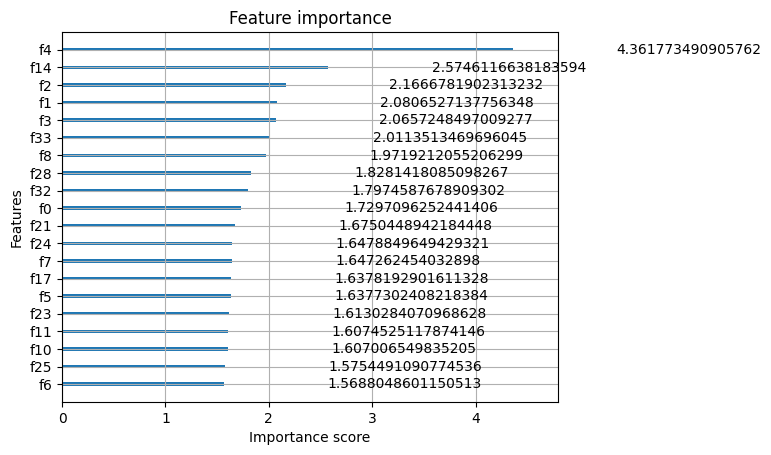

In [215]:
xgb.plot_importance(model, importance_type="gain", max_num_features=20)
plt.show()

In [216]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot',
       'position_name_Center Attacking Midfield',
       'position_name_Center Defensive Midfield',
       'position_name_Center Forward', 'position_name_Left Attacking Midfield',
       'position_name_Left Back', 'position_name_Left Center Forward',
       'position_name_Left Center Midfield',
       'position_name_Left Defensive Midfield', 'position_name_Left Midfield',
       'position_name_Left Wing', 'position_name_Left Wing Back',
       'position_name_Right Attacking Midfield', 'position_name_Right 

In [217]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(10))

     importance
f4     4.361773
f14    2.574612
f2     2.166678
f1     2.080653
f3     2.065725
f33    2.011351
f8     1.971921
f28    1.828142
f32    1.797459
f0     1.729710


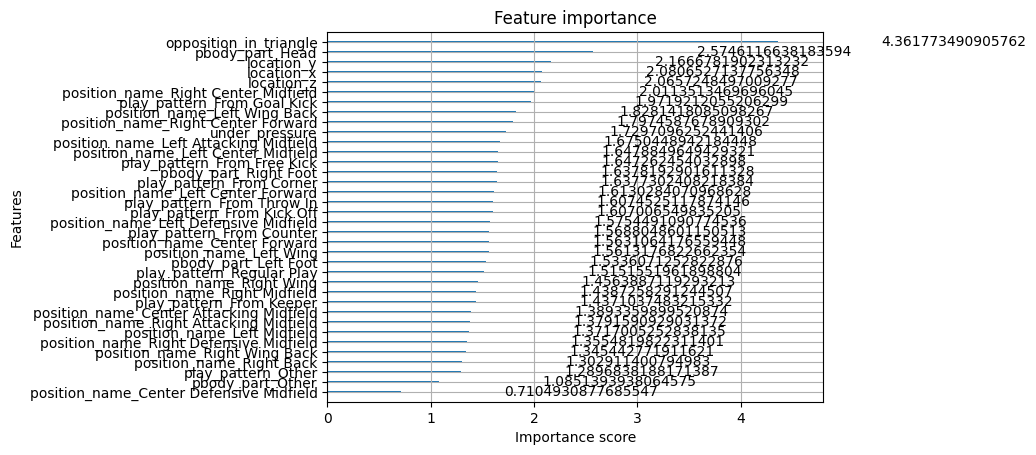

In [218]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()


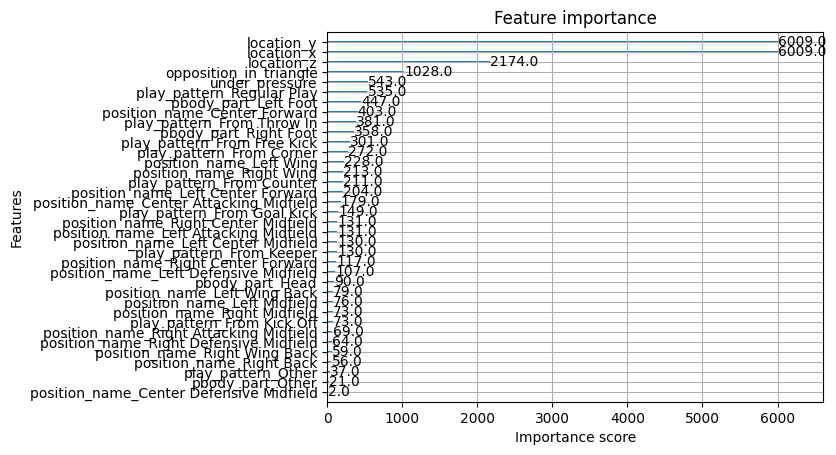

In [219]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="weight")
plt.show()


add physical metrics

In [220]:
def workload_index(df, period):
    return (
        df[f"Total Distance_{period}"] +
        2 * df[f"High Speed Running (HSR) Distance_{period}"] +
        3 * df[f"Sprinting Distance_{period}"] 
    )

# Example: compute workload index for different periods
for period in ["now", "half", "game", "1_week", "2_week", "1_month"]:
    shot_metrics_df[f"WI_{period}"] = workload_index(shot_metrics_df, period)

# Compute ACWR (Acute:Chronic Workload Ratio)
shot_metrics_df["ACWR"] = shot_metrics_df["WI_1_week"] / shot_metrics_df["WI_1_month"]
shot_metrics_df["ACWR"] = np.where(shot_metrics_df["ACWR"].isna(), 0,shot_metrics_df["ACWR"])
shot_metrics_df["ACWR"] = np.where(shot_metrics_df["ACWR"]>0.9, shot_metrics_df["ACWR"]*0.8,shot_metrics_df["ACWR"])
shot_metrics_df["ACWR_bucket"] = pd.cut(
    shot_metrics_df["ACWR"],
    bins=4, 
    labels=["Q1 (lowest)", "Q2", "Q3","Q4"]
)
shot_metrics_df["ACWR_pos"] = np.where(shot_metrics_df["ACWR"]>0, 1,0)

In [221]:
len(shot_metrics_df[shot_metrics_df["ACWR"]==0])

2974

In [222]:
for thing in shot_metrics_df["ACWR_bucket"].unique():
    print(shot_metrics_df[shot_metrics_df["ACWR_bucket"]==thing].ACWR.max())

0.22368027394688536
0.8947831374243138
0.6705803504038514
0.446865242267933


<Axes: ylabel='Density'>

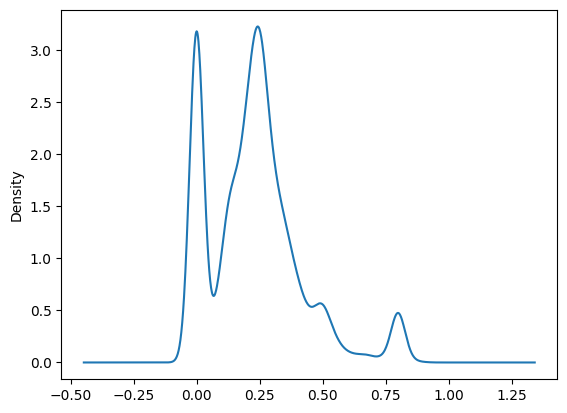

In [223]:
shot_metrics_df["ACWR"].plot.density()

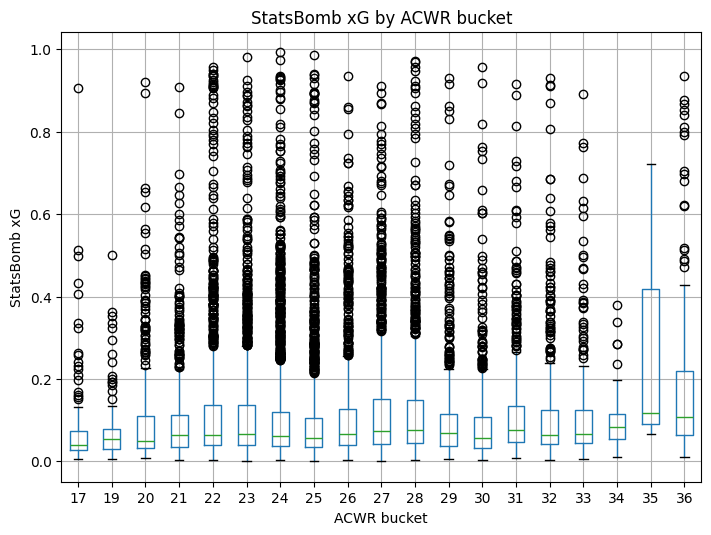

In [224]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg", by="age", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

In [225]:
ML_data= shot_metrics_df[[
    "age","team_name","goal", "under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle",
    'WI_now', 'WI_game', 'WI_1_week','WI_2_week','WI_1_month',
       'ACWR','ACWR_bucket',
        'ACWR_pos'
    #"position_name",
    #"Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    #"Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    #"High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    #"Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    #"Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    #"Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    #"High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    #"Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    #"Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    #"Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    #"High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    #"Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
#position_name_onehot = pd.get_dummies(ML_data.position_name, 
#    prefix="position_name")#, dtype=float)
acwr_onehot = pd.get_dummies(ML_data.ACWR_bucket, 
    prefix="acwr")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot,acwr_onehot ], axis=1).drop(["play_pattern_name","body_part",'ACWR_bucket'],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

just players with over 100 shots?

<Axes: ylabel='Density'>

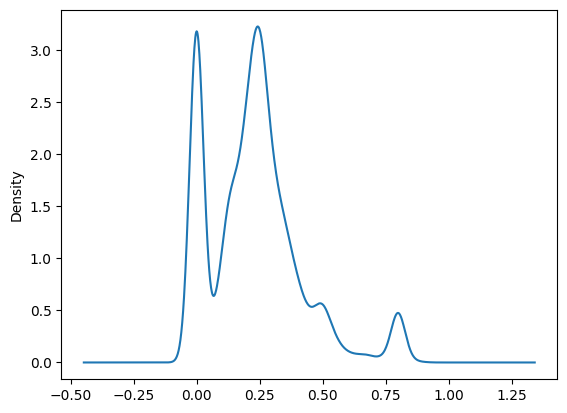

In [226]:
ML_data.ACWR.plot.density()

In [227]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score


# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 6.60


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[868,  14],
       [137,  24]])

In [ ]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[875,   7],
       [129,  32]])

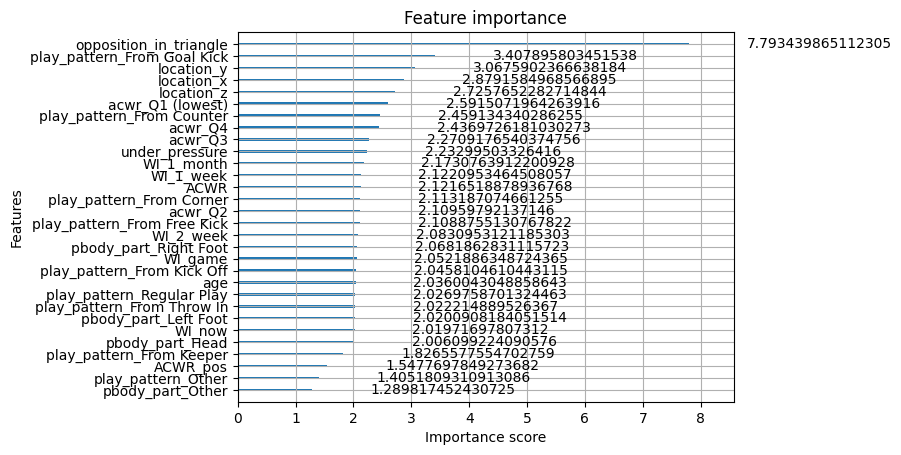

In [ ]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()

In [ ]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(30))

                             importance
opposition_in_triangle         7.793440
play_pattern_From Goal Kick    3.407896
location_y                     3.067590
location_x                     2.879158
location_z                     2.725765
acwr_Q1 (lowest)               2.591507
play_pattern_From Counter      2.459134
acwr_Q4                        2.436973
acwr_Q3                        2.270918
under_pressure                 2.232995
WI_1_month                     2.173076
WI_1_week                      2.122095
ACWR                           2.121652
play_pattern_From Corner       2.113187
acwr_Q2                        2.109598
play_pattern_From Free Kick    2.108876
WI_2_week                      2.083095
pbody_part_Right Foot          2.068186
WI_game                        2.052189
play_pattern_From Kick Off     2.045810
age                            2.036004
play_pattern_Regular Play      2.026976
play_pattern_From Throw In     2.022215
pbody_part_Left Foot           2.020091


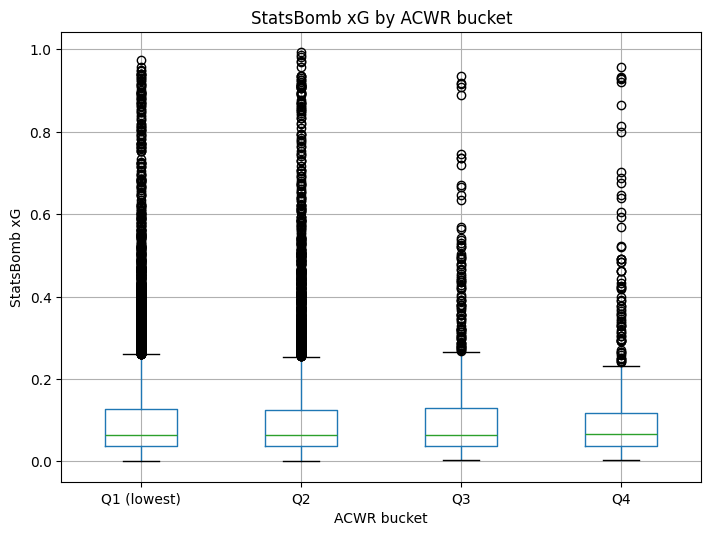

In [ ]:
import plotly.express as px
df = shot_metrics_df.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="statsbomb_xg", by="ACWR_bucket", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

if not better explanation maybe different shots?

does match by match tiredness reduce shot number (quality) in next game? avg xg per shot?

match_date player avg_shot_xg (max ).str.endswith(('1_week', '2_week', '1_month')

In [ ]:
shot_metrics_df.head(1)

Unnamed: 0                              event_id  event_index  period  \
0           0  24392d1d-314a-4063-a729-7775bc0a2c45        130.0     1.0   

      timestamp  minute  second  possession  duration  obv_for_after  \
0  00:03:04.524     3.0     4.0         9.0  0.471596       0.306241   

   obv_for_before  obv_for_net  obv_against_after  obv_against_before  \
0        0.278243     0.027997           0.007197            0.007197   

   obv_against_net  obv_total_net  under_pressure  type_id type_name  \
0              0.0       0.027997               1     16.0      Shot   

   possession_team_id possession_team_name  play_pattern_id play_pattern_name  \
0                36.0      Manchester City              2.0       From Corner   

   team_id        team_name  location_x  location_y  location_z  \
0     36.0  Manchester City       112.7        39.9        0.22   

                                      related_events  player_id  \
0  67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...    23616.0   

     player_name  position_id   position_name  statsbomb_xg  goal  penalty  \
0  Erling Håland         23.0  Center Forward      0.166126   1.0      0.0   

   body_part  opposition_in_triangle   gameId  match_date  Count HI_now  \
0  Left Foot                     1.0  3892755  2023-08-11           1.2   

   Count HI_half  Count HI_game  Count HSR_now  Count HSR_half  \
0            0.0            0.0            1.0             0.0   

   Count HSR_game  Count High Acceleration_now  Count High Acceleration_half  \
0             0.0                          0.2                           0.0   

   Count High Acceleration_game  Count High Deceleration_now  \
0                           0.0                          0.4   

   Count High Deceleration_half  Count High Deceleration_game  \
0                           0.0                           0.0   

   Count Medium Acceleration_now  Count Medium Acceleration_half  \
0                            6.8                             0.0   

   Count Medium Acceleration_game  Count Medium Deceleration_now  \
0                             0.0                            4.4   

   Count Medium Deceleration_half  Count Medium Deceleration_game  \
0                             0.0                             0.0   

   Count Sprint_now  Count Sprint_half  Count Sprint_game  \
0               0.2                0.0                0.0   

   High Intensity (HI) Distance_now  High Intensity (HI) Distance_half  \
0                         17.017352                                0.0   

   High Intensity (HI) Distance_game  High Speed Running (HSR) Distance_now  \
0                                0.0                              15.196193   

   High Speed Running (HSR) Distance_half  \
0                                     0.0   

   High Speed Running (HSR) Distance_game  M/min_now  M/min_half  M/min_game  \
0                                     0.0  20.433466         0.0         0.0   

   Max Speed_now  Max Speed_half  Max Speed_game  Running Distance_now  \
0       5.187833             0.0             0.0             37.352316   

   Running Distance_half  Running Distance_game  Sprinting Distance_now  \
0                    0.0                    0.0                1.821159   

   Sprinting Distance_half  Sprinting Distance_game  Total Distance_now  \
0                      0.0                      0.0          306.501986   

   Total Distance_half  Total Distance_game  Count HI_1_week  \
0                  0.0                  0.0              0.0   

   Count HSR_1_week  Count High Acceleration_1_week  \
0               0.0                             0.0   

   Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                             0.0                               0.0   

   Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                               0.0                  0.0   

   High Intensity (HI) Distance_1_week  \
0                        

In [ ]:
pattern_cols = shot_metrics_df.filter(regex='_(1_week|2_week|1_month)$').columns
#pattern_cols = shot_metrics_df.filter(regex='ACWR').columns
specific_cols = ["team_id", "match_date", "statsbomb_xg","ACWR","ACWR_pos","ACWR_bucket"]#"player_id"


In [ ]:
shot_metrics_df[specific_cols + list(pattern_cols)]

team_id  match_date  statsbomb_xg      ACWR  ACWR_pos  ACWR_bucket  \
0         36.0  2023-08-11      0.166126  0.000000         0  Q1 (lowest)   
1         36.0  2023-08-11      0.023693  0.000000         0  Q1 (lowest)   
2         36.0  2023-08-11      0.142146  0.000000         0  Q1 (lowest)   
6         36.0  2023-08-11      0.139437  0.000000         0  Q1 (lowest)   
8         36.0  2023-08-11      0.228048  0.000000         0  Q1 (lowest)   
...        ...         ...           ...       ...       ...          ...   
61639     39.0  2025-05-21      0.011114  0.329450         1           Q2   
61641     38.0  2025-05-21      0.694506  0.072077         1  Q1 (lowest)   
61642     39.0  2025-05-21      0.046117  0.329450         1           Q2   
61647     39.0  2025-05-21      0.121914  0.329450         1           Q2   
61648     39.0  2025-05-21      0.036180  0.088722         1  Q1 (lowest)   

       Count HI_1_week  Count HSR_1_week  Count High Acceleration_1_week  \
0                  0.0               0.0                             0.0   
1                  0.0               0.0                             0.0   
2                  0.0               0.0                             0.0   
6                  0.0               0.0                             0.0   
8                  0.0               0.0                             0.0   
...                ...               ...                             ...   
61639             50.0              33.0                            25.0   
61641              6.0               5.0                             4.0   
61642             50.0              33.0                            25.0   
61647             50.0              33.0                            25.0   
61648             14.0              12.0                             5.0   

       Count High Deceleration_1_week  Count Medium Acceleration_1_week  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
6                                 0.0                               0.0   
8                                 0.0                               0.0   
...                               ...                               ...   
61639                            29.0                             173.0   
61641                             3.0                              15.0   
61642                            29.0                             173.0   
61647                            29.0                             173.0   
61648                            10.0                              47.0   

       Count Medium Deceleration_1_week  Count Sprint_1_week  \
0                                   0.0                  0.0   
1                                   0.0                  0.0   
2                                   0.0                  0.0   
6                                   0.0                  0.0   
8                                   0.0                  0.0   
...                                 ...                  ...   
61639                             154.0                 17.0   
61641                              19.0                  1.0   
61642                             154.0                 17.0   
61647                             154.0                 17.0   
61648                              40.0                  2.0   

       High Intensity (HI) Distance_1_week  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
6                                 0.000000   
8                                 0.000000   
...                                    ...   
61639                           871.172607   
61641                            50.848873   
61642                           871.172607   
61647                           871.172

In [ ]:
shots_by_player_match = shot_metrics_df[specific_cols + list(pattern_cols)]#.groupby(["player_id","match_date"],as_index=False).min()

In [ ]:
#shots_by_player_match = shot_metrics_df[["player_id", "match_date", "statsbomb_xg","ACWR","ACWR_pos","ACWR_bucket"]]

In [ ]:
shots_by_player_match.columns

Index(['team_id', 'match_date', 'statsbomb_xg', 'ACWR', 'ACWR_pos',
       'ACWR_bucket', 'Count HI_1_week', 'Count HSR_1_week',
       'Count High Acceleration_1_week', 'Count High Deceleration_1_week',
       'Count Medium Acceleration_1_week', 'Count Medium Deceleration_1_week',
       'Count Sprint_1_week', 'High Intensity (HI) Distance_1_week',
       'High Speed Running (HSR) Distance_1_week', 'M/min_1_week',
       'Max Speed_1_week', 'Running Distance_1_week',
       'Sprinting Distance_1_week', 'Total Distance_1_week', 'Count HI_2_week',
       'Count HSR_2_week', 'Count High Acceleration_2_week',
       'Count High Deceleration_2_week', 'Count Medium Acceleration_2_week',
       'Count Medium Deceleration_2_week', 'Count Sprint_2_week',
       'High Intensity (HI) Distance_2_week',
       'High Speed Running (HSR) Distance_2_week', 'M/min_2_week',
       'Max Speed_2_week', 'Running Distance_2_week',
       'Sprinting Distance_2_week', 'Total Distance_2_week',
       'Count H

In [ ]:
group_col = ["team_id","match_date"]#player_id
mean_col = 'statsbomb_xg'

other_cols = [col for col in shots_by_player_match.columns if col not in group_col]

agg_dict = {mean_col: ['mean', 'sum', 'count']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

shots_by_player_match = shots_by_player_match.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
shots_by_player_match.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in shots_by_player_match.columns]



TypeError: category dtype does not support aggregation 'mean'

In [ ]:
#shot_metrics_df[(shot_metrics_df.player_id==106904.0) |(shot_metrics_df.player_id==199774.0)].to_csv("what.csv")

Maybe take just strikers with over 30 shots or 100 or whatever

In [ ]:
good_shooters = shot_metrics_df[["player_id","statsbomb_xg"]].groupby("player_id",as_index=False).count().sort_values(by="statsbomb_xg", ascending=False)
good_shooters = good_shooters[good_shooters["statsbomb_xg"]>99]
shots_by_player_match_good =  shots_by_player_match[shots_by_player_match["player_id"].isin(good_shooters.player_id)]
shots_by_player_match_good.head()

player_id  match_date  statsbomb_xg_mean  statsbomb_xg_sum  \
0     3009.0  2024-08-18           0.080226          0.320904   
1     3009.0  2024-08-25           0.161061          0.644246   
2     3009.0  2024-08-29           0.048426          0.435835   
3     3009.0  2024-09-01           0.106009          0.848074   
4     3009.0  2024-09-14           0.071585          0.143170   

   statsbomb_xg_count  ACWR_max  ACWR_pos_max ACWR_bucket_max  \
0                   4  0.000000             0     Q1 (lowest)   
1                   4  0.800000             1              Q4   
2                   9  0.501516             1              Q3   
3                   8  0.670316             1              Q3   
4                   2  0.137241             1     Q1 (lowest)   

   Count HI_1_week_max  Count HSR_1_week_max  \
0             0.000000              0.000000   
1            56.000000             37.000000   
2            52.000000             27.000000   
3            99.000000             53.000000   
4            36.286577             21.633757   

   Count High Acceleration_1_week_max  Count High Deceleration_1_week_max  \
0                            0.000000                            0.000000   
1                           36.000000                           48.000000   
2                           36.000000                           42.000000   
3                           58.000000                           71.000000   
4                           24.135458                           25.874736   

   Count Medium Acceleration_1_week_max  Count Medium Deceleration_1_week_max  \
0                              0.000000                              0.000000   
1                            165.000000                            131.000000   
2                            163.000000                            126.000000   
3                            351.000000                            265.000000   
4                            128.134742                             97.566338   

   Count Sprint_1_week_max  High Intensity (HI) Distance_1_week_max  \
0                  0.00000                                 0.000000   
1                 19.00000                               635.607910   
2                 25.00000                               830.930115   
3                 46.00000                              1548.059143   
4                 14.65282                               558.183085   

   High Speed Running (HSR) Distance_1_week_max  M/min_1_week_max  \
0                                      0.000000          0.000000   
1                                    409.020020         95.428116   
2                                    473.635590         91.261585   
3                                    877.324402        192.355580   
4                                    331.139777         75.778753   

   Max Speed_1_week_max  Running Distance_1_week_max  \
0              0.000000                     0.000000   
1             34.183289                   886.372742   
2             34.467615                   847.014832   
3             70.235844                  1947.864197   
4             27.527912                   688.114285   

   Sprinting Distance_1_week_max  Total Distance_1_week_max  \
0                       0.000000                   0.000000   
1                     226.587906                9655.734833   
2                     357.294525                9202.209863   
3                     670.734711               18910.603183   
4                     227.043311                7030.505010   

   Count HI_2_week_max  Count HSR_2_week_max  \
0             0.000000              0.000000   
1            56.000000             37.000000   
2           108.000000             64.000000   
3           155.000000             90.000000   
4           116.573154             69.267514   

   Count High Acceleration_2_week_max  Count High Deceleration_2_week_max  \
0                            0.000000                     

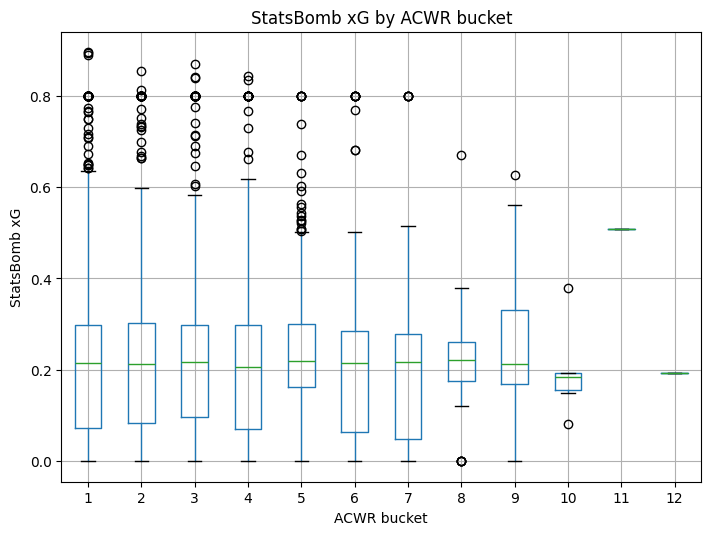

In [ ]:
import plotly.express as px
df = shots_by_player_match_good.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="ACWR_max", by="statsbomb_xg_count", ax=ax)

# Beautify
ax.set_title("StatsBomb xG by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("StatsBomb xG")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()

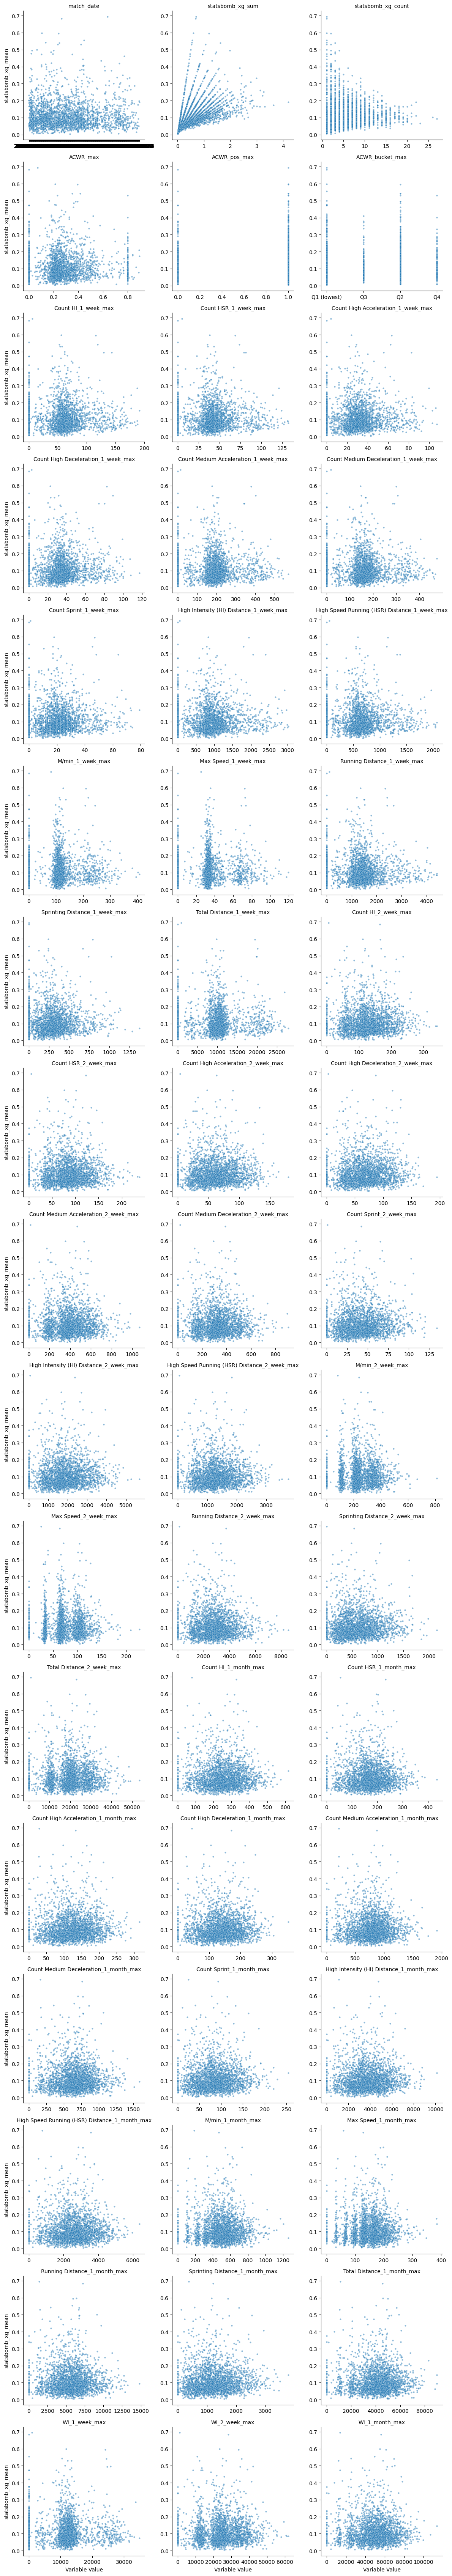

In [ ]:
target = "statsbomb_xg_mean"

# Select the variables you want to plot against statsbomb_xg_mean
# Exclude the target itself and any other columns you don't want to plot
plot_variables = [col for col in shots_by_player_match.columns 
                  if col != target and col not in ['team_id']]  # player_id, 'player_name'

df_melted = shots_by_player_match.melt(id_vars=[target], 
                                      value_vars=plot_variables,
                                      var_name="variable", 
                                      value_name="x_value")

g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="x_value", y=target, alpha=0.5, s=10)
g.set_titles(col_template="{col_name}")
g.set_axis_labels(x_var="Variable Value", y_var=target)
plt.tight_layout()
plt.show()

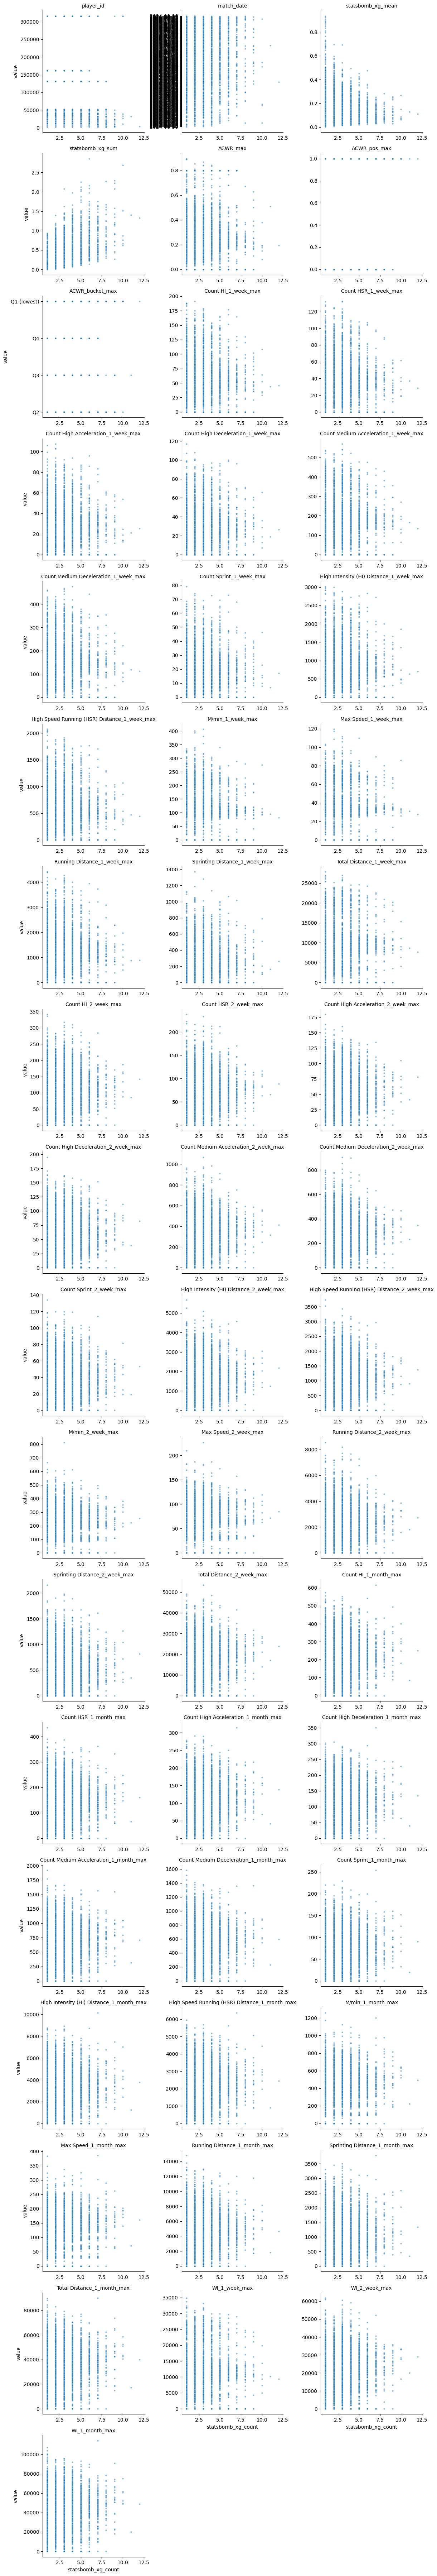

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

target = "statsbomb_xg_count"
df_melted = shots_by_player_match_good.melt(id_vars=target, var_name="variable", value_name="value")

g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x=target, y="value", alpha=0.5, s=10)
g.set_titles(col_template="{col_name}")
plt.show()


so we have:
looked at individual shots to xg
match level statistics
including just top players

to do:
do tired players exceed / underperform their xg
within games: does it get worse as game goes on (quality/quantity)
within team, does shot quality get worse as fatigue builds (dont have stats for whole team currently, just shooter)
